# Example: NXWriter callback

**NOTE**: work-in-progress

**Objective**

Demonstrate use of `apstools.callbacks.NXWriter` and
`apstools.callbacks.NXWriterAPS` as callbacks and then use either (or both) to
export data from databroker.

**Contents**

- [Use as callback](#Use-as-callback)
- [Export data](#Export-data)

## Use as callback


In [1]:
%matplotlib inline
from apstools.synApps import setup_random_number_swait
from apstools.synApps import SwaitRecord
from bluesky import RunEngine
from bluesky import SupplementalData
from bluesky import plans as bp
from bluesky.callbacks.best_effort import BestEffortCallback
from matplotlib import pyplot as plt
from ophyd import EpicsMotor
from ophyd import EpicsSignalRO
import databroker

IOC = "gp:"

# ophyd-level
motor = EpicsMotor(f"{IOC}m10", name="motor")
calc9 = SwaitRecord(f"{IOC}userCalc9", name="calc9")
calc10 = SwaitRecord(f"{IOC}userCalc10", name="calc10")
sensor = EpicsSignalRO(calc10.calculated_value.pvname, name="sensor")
sensor2 = EpicsSignalRO(calc9.calculated_value.pvname, name="sensor2")
calc9.wait_for_connection()
calc10.wait_for_connection()
motor.wait_for_connection()
sensor.wait_for_connection()
sensor2.wait_for_connection()
setup_random_number_swait(calc9)
setup_random_number_swait(calc10)

# bluesky-level
best_effort_callback = BestEffortCallback()
cat = databroker.temp().v2
supplemental_data = SupplementalData()
plt.ion()
RE = RunEngine({})
RE.subscribe(cat.v1.insert)
RE.subscribe(best_effort_callback)
RE.preprocessors.append(supplemental_data)
# best_effort_callback.disable_plots

In [2]:
from apstools.callbacks import NXWriter
import pathlib

h5_file = pathlib.Path("/tmp/nxwriter.h5")

nxwriter = NXWriter()
nxwriter.file_name = str(h5_file)
RE.subscribe(nxwriter.receiver)

supplemental_data.baseline.append(calc9)
supplemental_data.baseline.append(calc10)
supplemental_data.monitors.append(sensor)
supplemental_data.monitors.append(sensor2)



Transient Scan ID: 1     Time: 2022-08-12 12:40:40
Persistent Unique Scan ID: '6cab8b3f-b9df-4a91-aafd-1c412a333120'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
+--------------------------------+--------------------------------+
New stream: 'sensor_monitor'
New stream: 'sensor2_monitor'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |     sensor |
+-----------+------------+------------+------------+
|         1 | 12:40:41.7 |   -0.50000 |    0.36197 |
|         2 | 12:40:42.2 |   -0.25000 |    0.39084 |
|         3 | 12:40:42.7 |    0.00000 |    0.91048 |
|         4 | 12:40:43.2 |    0.25000 |    0.73101 |
|         5 | 12:40:43.7 |    0.50000 |    0.99979 |
+-----------+------------+------------+------------+
generator scan ['6cab8b3f'] (scan num: 1)
End-of-run baseline readings:
+--------------------------------+--------------------------

'HDF5 address /entry/instrument/bluesky/streams/baseline/monochromator_dcm_wavelength/value_start not found.' -- not creating monochromator group
'HDF5 address /entry/instrument/bluesky/streams/baseline/sample_data_chemical_formula/value_start not found.'
'HDF5 address /entry/instrument/bluesky/streams/baseline/sample_data_concentration/value_start not found.'
'HDF5 address /entry/instrument/bluesky/streams/baseline/sample_data_description/value_start not found.'
'HDF5 address /entry/instrument/bluesky/streams/baseline/sample_data_electric_field/value_start not found.'
'HDF5 address /entry/instrument/bluesky/streams/baseline/sample_data_magnetic_field/value_start not found.'
'HDF5 address /entry/instrument/bluesky/streams/baseline/sample_data_rotation_angle/value_start not found.'
'HDF5 address /entry/instrument/bluesky/streams/baseline/sample_data_scattering_length_density/value_start not found.'
'HDF5 address /entry/instrument/bluesky/streams/baseline/sample_data_stress_field/value_s

h5_file.exists()=True  h5_file=PosixPath('/tmp/nxwriter.h5')


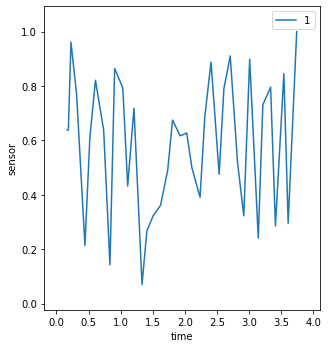

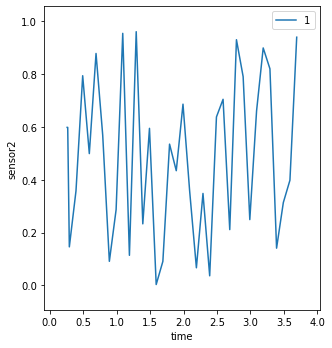

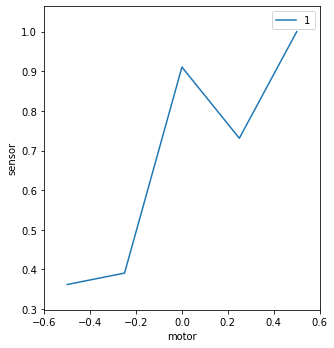

In [3]:
RE(bp.scan([sensor], motor, -0.5, 0.5, 5))
print(f"{h5_file.exists()=}  {h5_file=}")

In [4]:
from apstools.utils import unix

for line in unix(f"punx tree {nxwriter.file_name}"):
    print(line.decode().strip())

!!! WARNING: this program is not ready for distribution.

/tmp/nxwriter.h5 : NeXus data file
  @HDF5_Version = "1.12.1"
  @NeXus_version = "v2020.1"
  @creator = "NXWriter"
  @default = "entry"
  @file_name = "/tmp/nxwriter.h5"
  @file_time = "2022-08-12T12:40:43.982975"
  @h5py_version = "3.7.0"
  entry:NXentry
    @NX_class = "NXentry"
    @default = "data"
    @target = "/entry"
    duration:NX_FLOAT64[] = 
      @units = "s"
    end_time:NX_CHAR = b'2022-08-12T12:40:43.818351'
    entry_identifier --> /entry/instrument/bluesky/metadata/run_start_uid
    plan_name --> /entry/instrument/bluesky/metadata/plan_name
    program_name:NX_CHAR = b'bluesky'
    start_time:NX_CHAR = b'2022-08-12T12:40:40.030735'
    title:NX_CHAR = b'scan-S0001-6cab8b3'
    data:NXdata
      @NX_class = "NXdata"
      @axes = ["motor"]
      @signal = "sensor"
      @target = "/entry/data"
      EPOCH --> /entry/instrument/bluesky/streams/primary/sensor/time
      motor --> /entry/instrument/bluesky/streams/

## Export data


In [5]:
from apstools.callbacks import NXWriter
from apstools.utils import replay
import databroker

# This example uses 'cat' as defined above.  You use this next line:
# cat = databroker.databroker["YOUR_CATALOG_NAME"]

h5_file = pathlib.Path("/tmp/db_export.h5")

scan_id = 1  # TODO: you choose
nxwriter = NXWriter()
nxwriter.file_name = str(h5_file)
replay(cat.v1[scan_id], nxwriter.receiver)
print(f"{h5_file.exists()=}  {h5_file=}")

'HDF5 address /entry/instrument/bluesky/streams/baseline/monochromator_dcm_wavelength/value_start not found.' -- not creating monochromator group
'HDF5 address /entry/instrument/bluesky/streams/baseline/sample_data_chemical_formula/value_start not found.'
'HDF5 address /entry/instrument/bluesky/streams/baseline/sample_data_concentration/value_start not found.'
'HDF5 address /entry/instrument/bluesky/streams/baseline/sample_data_description/value_start not found.'
'HDF5 address /entry/instrument/bluesky/streams/baseline/sample_data_electric_field/value_start not found.'
'HDF5 address /entry/instrument/bluesky/streams/baseline/sample_data_magnetic_field/value_start not found.'
'HDF5 address /entry/instrument/bluesky/streams/baseline/sample_data_rotation_angle/value_start not found.'
'HDF5 address /entry/instrument/bluesky/streams/baseline/sample_data_scattering_length_density/value_start not found.'
'HDF5 address /entry/instrument/bluesky/streams/baseline/sample_data_stress_field/value_s

h5_file.exists()=True  h5_file=PosixPath('/tmp/db_export.h5')
